In [38]:
# Import packages
import os
from matplotlib import pyplot as plt
import pandas as pd

# Import AuTuMN modules
from autumn.settings import Models, Region
from autumn.settings.folders import OUTPUT_DATA_PATH, PROJECTS_PATH
from autumn.core.project import get_project
from autumn.core import db
from autumn.core.plots.calibration.plots import get_output_from_run_id
from autumn.core.plots.uncertainty.plots import _plot_uncertainty, _get_target_values
from autumn.core.plots.plotter.base_plotter import COLOR_THEME
from autumn.core.plots.utils import change_xaxis_to_date, REF_DATE, ALPHAS, COLORS, _apply_transparency, _plot_targets_to_axis

from autumn.calibration.utils import get_uncertainty_df
import matplotlib.patches as mpatches
import json

from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes, mark_inset
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar


In [2]:
# Specify model details
model = Models.SM_SIR
region = Region.NCR
date = "2022-06-21"
# assumption = "none"
dirname = date

include_scenario_descriptions = False

In [3]:
# get the relevant project and output data
project = get_project(model, region)
project_calib_dir = os.path.join(
    OUTPUT_DATA_PATH, "calibrate", project.model_name, project.region_name
)
calib_path = os.path.join(project_calib_dir, dirname)
# Load tables
mcmc_tables = db.load.load_mcmc_tables(calib_path)
mcmc_params = db.load.load_mcmc_params_tables(calib_path)

uncertainty_df = get_uncertainty_df(calib_path, mcmc_tables, project.plots)
scenario_list = uncertainty_df['scenario'].unique()

# make output directories
output_dir = dirname
base_dir = os.path.join("outputs", output_dir)
os.makedirs(base_dir, exist_ok=True)
dirs_to_make = ["calibration", "median", "uncertainty", "csv_files"]
for dir_to_make in dirs_to_make:
    os.makedirs(os.path.join(base_dir, dir_to_make), exist_ok=True)

In [44]:
titles = {
    "notifications": "Daily number of notified COVID-19 cases",
    "infection_deaths":"Daily number of COVID-19 deaths", # "Cumulative deaths since 1 Mar 2021", # ,
    "accum_deaths": "Cumulative number of COVID-19 deaths",
    "accum_incidence": "Cumulative number of COVID-19 infections",
    "incidence": "Daily incidence (incl. asymptomatics and undetected)", # "Cumulative infections since 1 Mar 2021", # ,
    "hospital_occupancy": "Hospital beds occupied by COVID-19 patients",
    "icu_occupancy": "ICU beds occupied by COVID-19 patients",
    "hospital_admissions":"Hospital admissions", #"Cumulative hospitalisations since 1 Mar 2021", #
    "cdr": "Proportion detected among symptomatics",
    "proportion_vaccinated": "Proportion vaccinated",
    "prop_incidence_strain_delta": "Proportion of Delta variant in new cases",
    "cumulative_notifications": "Accumulated COVID-19 notifications",
    "cumulative_hospital_admissions": "Accumulated COVID-19 hospital admissions",
    "cumulative_icu_admissions": "Accumulated COVID-19 ICU admissions",
}

legend_titles = {
    0: "Baseline",
}
if include_scenario_descriptions:
    legend_titles.update(
        {sc: f"Sc. {sc}: {project.param_set.scenarios[sc-1].to_dict()['description']}" for sc in scenario_list if sc > 0}
    )
else:
    legend_titles.update(
        {sc: f"Sc. {sc}" for sc in scenario_list if sc > 0}
    )


C:\Users\rrag0004\AppData\Local\Temp\ipykernel_10044\2883054030.py:99: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


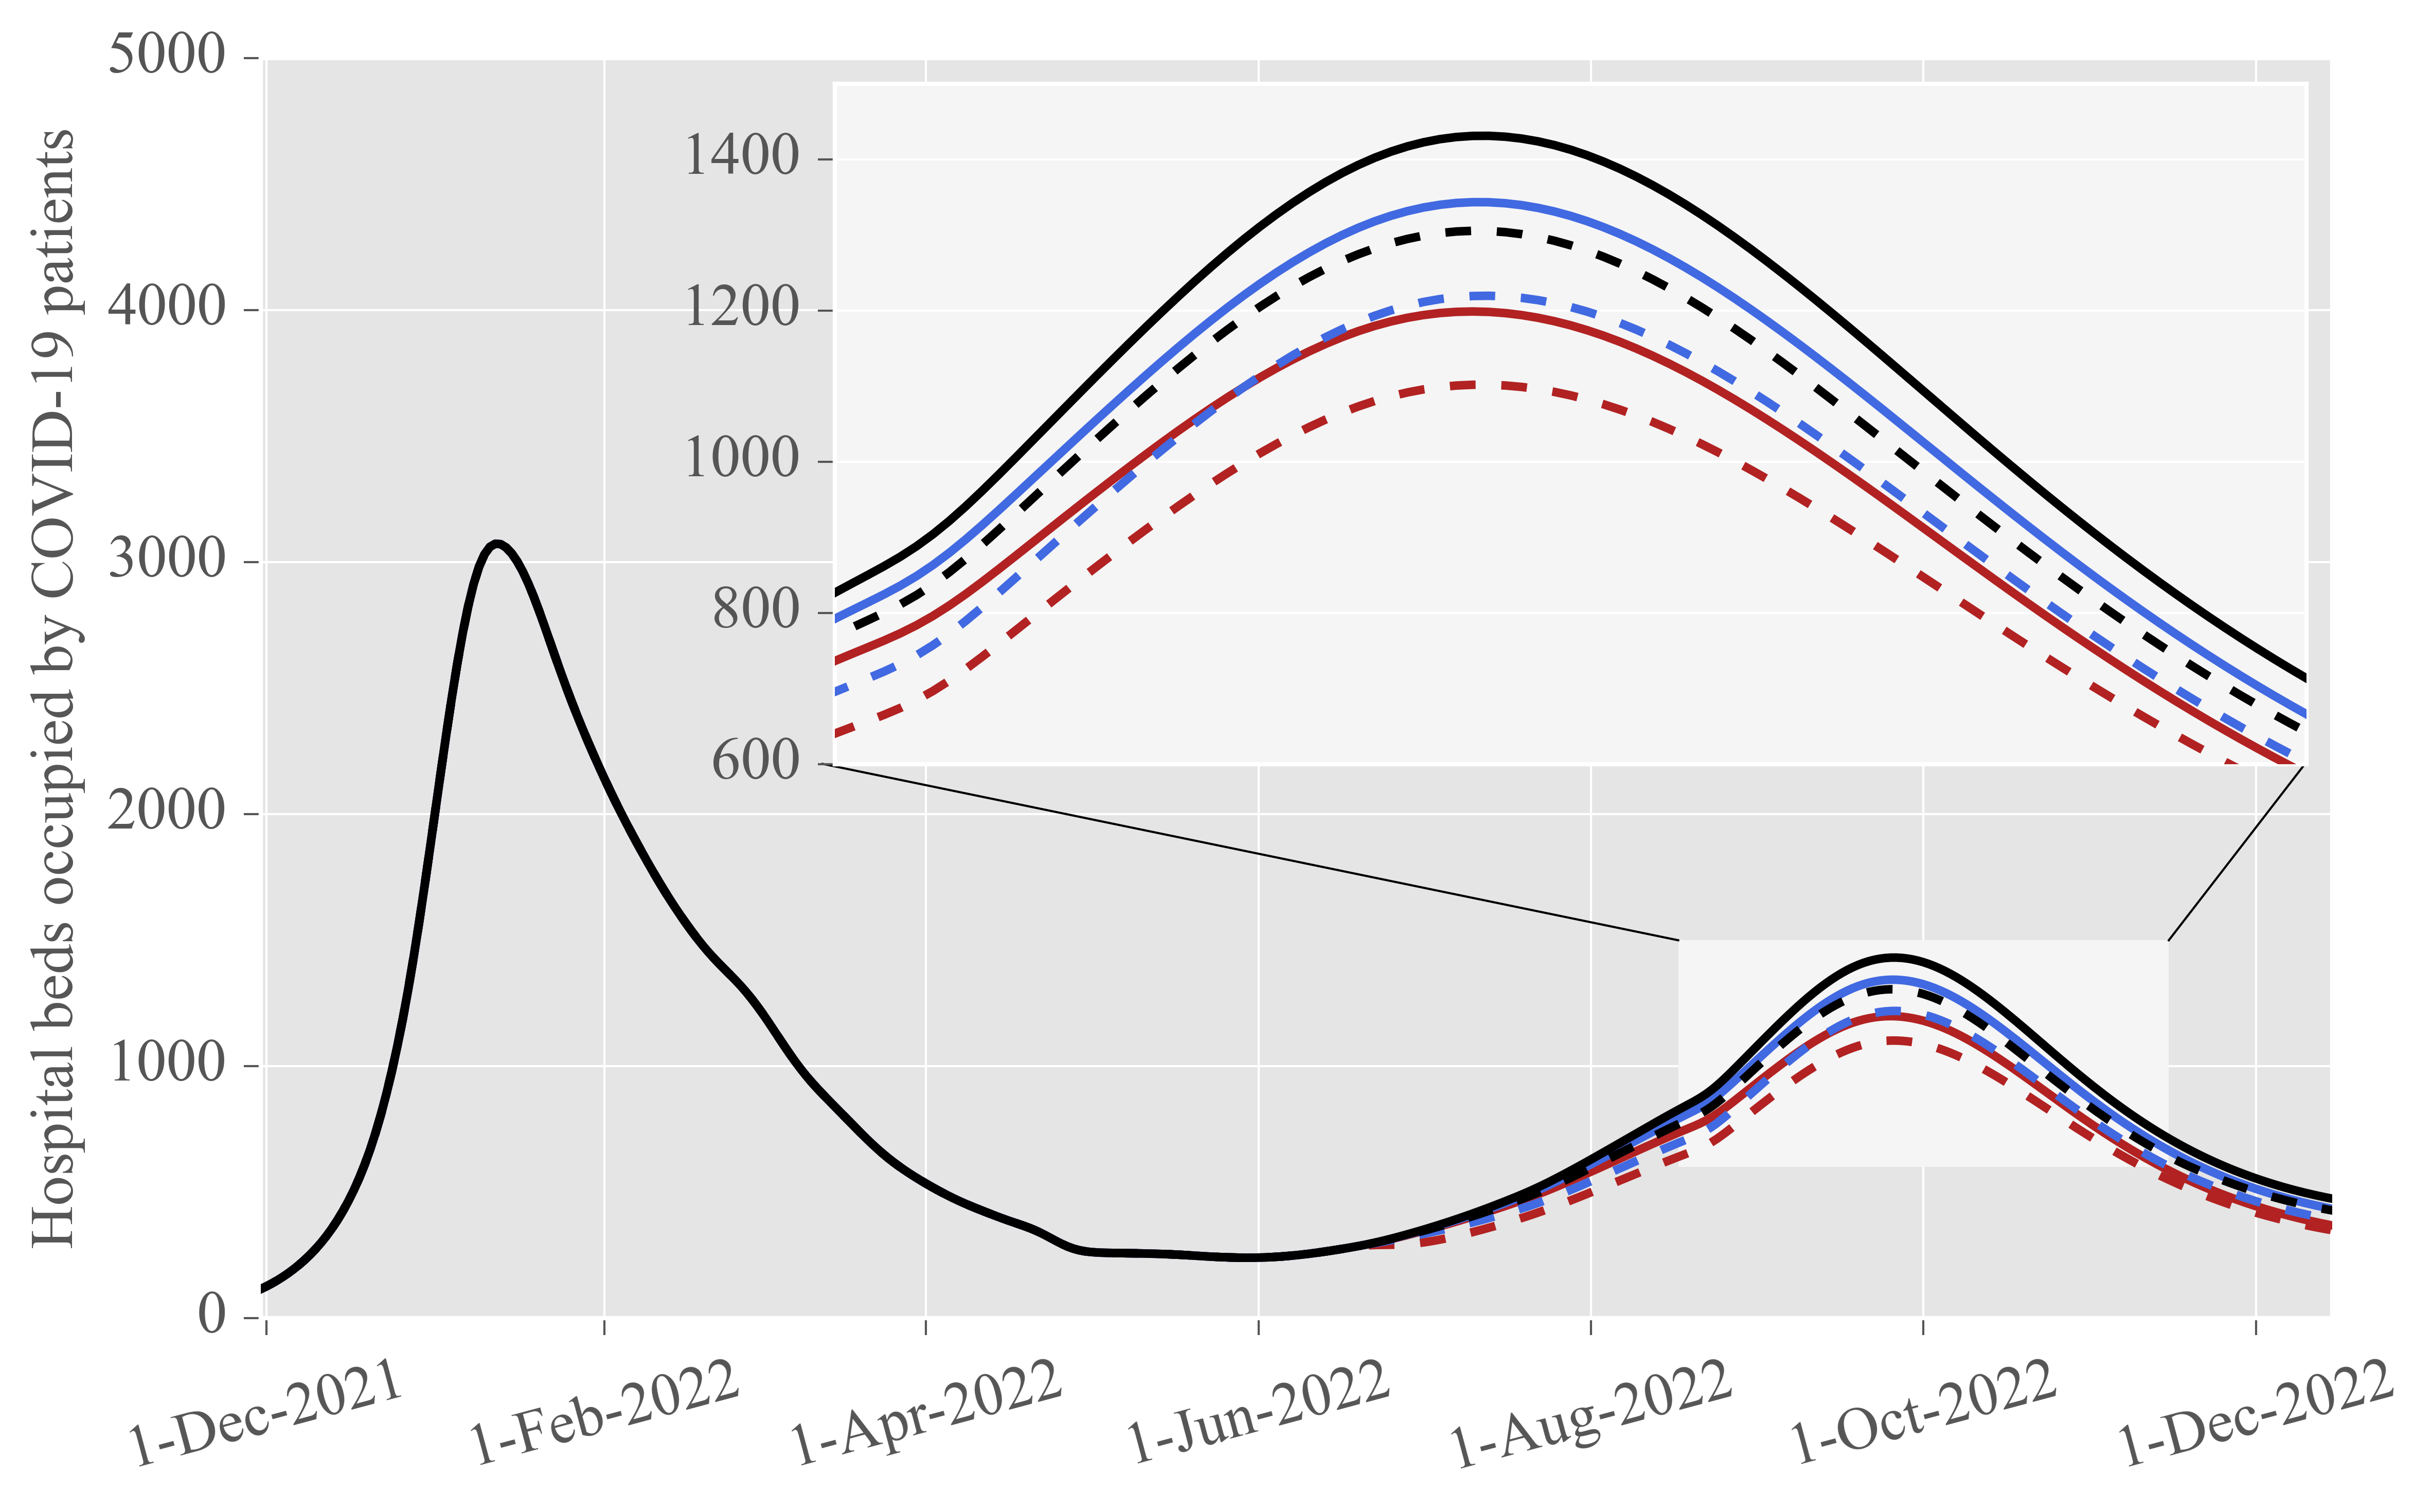

In [193]:
zoom_xlim = (960, 1050)
zoom_ylim = (600, 1500)
inset_color = "whitesmoke"
plt.rcParams["font.family"] = "Times New Roman"

def _plot_scenarios(zoom, axis, scenario_list, sc_linestyles, sc_colors, output_name, mcmc_tables, derived_output_tables, cumul_from, linewidth, xmin, xmax, label_font_size, n_xticks):

    for i, scenario in enumerate(scenario_list):    
        linestyle = sc_linestyles[scenario]
        color = sc_colors[scenario]
        zorder = 100 - scenario

        times, values = get_output_from_run_id(output_name, mcmc_tables, derived_output_tables, "MLE", scenario)
        if cumul_from is not None:
            ref_ind = list(times).index(cumul_from)
            cum_values = [0] * (ref_ind + 1) + [sum(values[ref_ind + 1: i]) for i in range(ref_ind + 1, len(values)) ] 
            values = cum_values
        
        axis.plot(times, values, color=color, linestyle=linestyle, linewidth=linewidth, zorder=zorder)

    axis.set_xlim((xmin, xmax))

    if zoom:
        y_min, y_max = zoom_ylim 
        axis.get_xaxis().set_visible(False)
        axis.set_yticks((600, 800, 1000 ,1200 ,1400))
    else:
        y_min, y_max=0., 5000    
        axis.set_xticks((701, 763, 822, 883, 944, 1005, 1066))

    axis.set_ylim((y_min, y_max))


    plt.setp(axis.get_yticklabels(), fontsize=label_font_size)
    plt.setp(axis.get_xticklabels(), fontsize=label_font_size)
    change_xaxis_to_date(axis, REF_DATE, rotation= 15)
    # plt.locator_params(axis="x", nbins=n_xticks)

def plot_outputs(output_type, output_name, scenario_list, sc_linestyles, sc_colors, show_v_lines=False, x_min=590, x_max=775, cumul_from=None):
    new_targets_path = os.path.join(PROJECTS_PATH, "sm_sir", "philippines", project.region_name, "new_targets.json")
    f = open(new_targets_path)
    new_targets = json.load(f)

    # plot options
    label_font_size = 14
    linewidth = 2.
    n_xticks = 5

    # initialise figure
    fig = plt.figure(figsize=(8, 5), dpi=600)
    plt.style.use("ggplot")
    axis = fig.add_subplot()
    # prepare colors for ucnertainty
    n_scenarios_to_plot = len(scenario_list)
    uncertainty_colors = _apply_transparency(COLORS[:n_scenarios_to_plot], ALPHAS[:n_scenarios_to_plot])

    if output_type == "MLE":
        derived_output_tables = db.load.load_derived_output_tables(calib_path, column=output_name)

    _plot_scenarios(False, axis, scenario_list, sc_linestyles, sc_colors, output_name, mcmc_tables, derived_output_tables, cumul_from, linewidth, x_min, x_max, label_font_size, n_xticks)
    axis.set_ylabel("Hospital beds occupied by COVID-19 patients", fontsize=label_font_size)

    # Inset
    axes_kwargs = {"facecolor": inset_color}
    axins = zoomed_inset_axes(axis, 3., loc=1, axes_kwargs=axes_kwargs)  # zoom = 6
    _plot_scenarios(True, axins, scenario_list, sc_linestyles, sc_colors, output_name, mcmc_tables, derived_output_tables, cumul_from, linewidth, zoom_xlim[0], zoom_xlim[1], label_font_size, n_xticks)    

    # Inset mark
    mark_inset(axis, axins, loc1=4, loc2=3, linewidth=0, color=inset_color)
    axis.plot([803, zoom_xlim[0]], [2200, zoom_ylim[1]], color="black", linewidth=.5, linestyle="-")
    axis.plot([1075, zoom_xlim[1]], [2200, zoom_ylim[1]], color="black", linewidth=.5, linestyle="-")

    visible_ticks = {
        "top": False,
        "right": False
    }
    axis.tick_params( which="both", **visible_ticks)
    axins.tick_params( which="both", **visible_ticks)

    return axis


scenario_x_min, scenario_x_max = 700,  1080 #1280 
output_names = ["hospital_occupancy"]
requested_scenario_list = [0, 2, 4, 6 ,8 , 10]

legends = [legend_titles[i] for i in requested_scenario_list]
sc_colors = ["black"] * 4 + ["royalblue"] * 4 + ["firebrick"] * 4
sc_linestyles = ["solid", "solid", "dashed", "dashed"] * 3

for output_type in ["MLE"]:
    for output_name in output_names:
        plot_outputs(output_type, output_name, requested_scenario_list, sc_linestyles, sc_colors, False, x_min=scenario_x_min, x_max=scenario_x_max
                    )# cumul_from=426)

#         plt.legend(legends, fontsize=14)
        path = os.path.join("outputs","viewpoint", "viewpoint_fig.jpg")
        
        plt.tight_layout()
        plt.savefig(path, dpi=600)
        
        # plt.close()